# Embedding feature visualization

## T-sne

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

# =======================
# Load Data
# =======================
# MiniLM
X_minilm = np.load("data/text_embeddings.npy")
# DeTeCtive
X_detective = np.load("data/detective_emb_384.npy")
# labels
y = pd.read_csv("data/data.csv")["label"].values

print("MiniLM:", X_minilm.shape, "DeTeCtive:", X_detective.shape, "Labels:", np.unique(y, return_counts=True))

# =======================
# Normalize (L2 norm)
# =======================
X_minilm = normalize(X_minilm)
X_detective = normalize(X_detective)

# =======================
# t-SNE to 2D
# =======================
tsne = TSNE(n_components=2, perplexity=80, random_state=42)

print("Running t-SNE for MiniLM...")
X_minilm_2d = tsne.fit_transform(X_minilm)

print("Running t-SNE for DeTeCtive...")
X_detective_2d = tsne.fit_transform(X_detective)

# =======================
# Plot
# =======================
colors = np.array(["#3B7DDD", "#E24A33"])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(
    X_minilm_2d[:, 0], X_minilm_2d[:, 1],
    c=colors[y],
    s=5, alpha=0.6
)
axes[0].set_title("MiniLM-L6-v3 Embedding (t-SNE 2D)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

axes[1].scatter(
    X_detective_2d[:, 0], X_detective_2d[:, 1],
    c=colors[y],
    s=5, alpha=0.6
)
axes[1].set_title("DeTeCtive Embedding (t-SNE 2D)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

## PCA

MiniLM PCA explained variance (2D): 0.0750
DeTeCtive PCA explained variance (2D): 0.9769


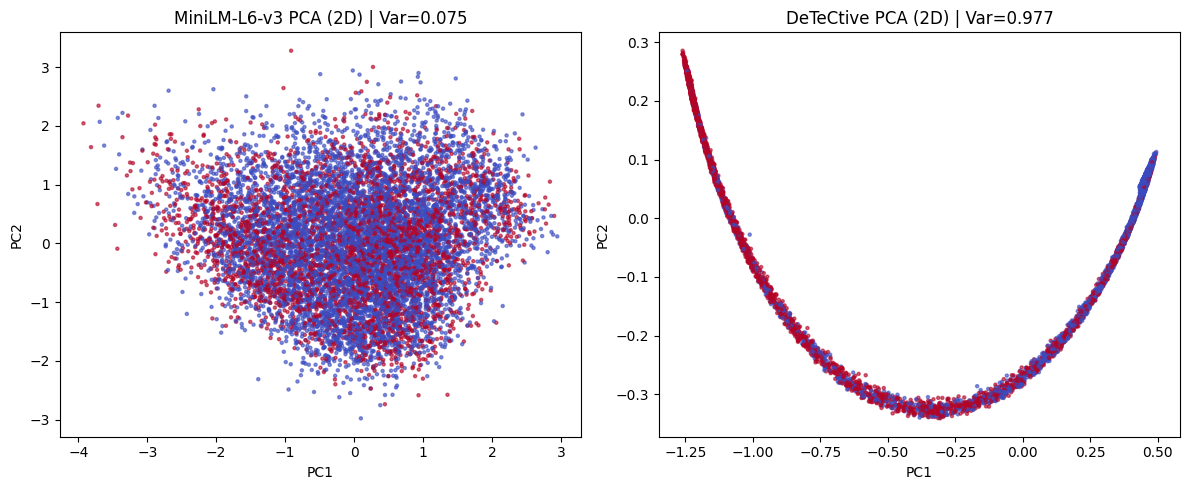

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

# =======================
# 加载数据
# =======================
X_minilm = np.load("data/text_embeddings.npy")
X_detective = np.load("data/detective_emb_384.npy")
y = pd.read_csv("data/data.csv")["label"].values


pca_minilm = PCA(n_components=2, random_state=42)
X_minilm_pca = pca_minilm.fit_transform(X_minilm)
explained_minilm = pca_minilm.explained_variance_ratio_.sum()

pca_detective = PCA(n_components=2, random_state=42)
X_detective_pca = pca_detective.fit_transform(X_detective)
explained_detective = pca_detective.explained_variance_ratio_.sum()

print(f"MiniLM PCA explained variance (2D): {explained_minilm:.4f}")
print(f"DeTeCtive PCA explained variance (2D): {explained_detective:.4f}")

# =======================
# 可视化
# =======================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(X_minilm_pca[:, 0], X_minilm_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[0].set_title(f"MiniLM-L6-v3 PCA (2D) | Var={explained_minilm:.3f}")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")

axes[1].scatter(X_detective_pca[:, 0], X_detective_pca[:, 1],
                c=y, cmap='coolwarm', s=5, alpha=0.6)
axes[1].set_title(f"DeTeCtive PCA (2D) | Var={explained_detective:.3f}")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")

plt.tight_layout()
plt.show()
